# Compare Lidar to Measured Tree Height

Your overall goal is to compare tree height measurements taken by humans in the field to height values extracted from a Lidar RS CHM. You are working with 2 different types of data:
1. Raster of the Lidar CHM and
2. Vector point location data

In the previous lesson, you learned how to extract raster values from an area derived by creating a buffer region around each point in a shp. This lesson, you will summarise the human made measurements and then compare them to Lidar.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import rasterstats as rs
from earthpy import spatial as es
import earthpy as et
import earthpy.plot as ep

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.axes_style("white")
sns.set(font_scale=1.5)

# Download data and set work dir
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

In [2]:
sjer_lidar_chm_path = os.path.join("data", "spatial-vector-lidar",
                                  "california", "neon-sjer-site",
                                  "2013", "lidar", "SJER_lidarCHM.tif")

# Load data
with rio.open(sjer_lidar_chm_path) as sjer_lidar_chm_src:
    SJER_chm_data = sjer_lidar_chm_src.read(1, masked=True)
    sjer_chm_meta = sjer_lidar_chm_src.profile
    sjer_chm_plt = plotting_extent(sjer_lidar_chm_src)
    
plot_buffer_path = "data/spatial-vector-lidar/outputs/plot_buffer.shp"

# Extract zonal stats & create geodataframe
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   SJER_chm_data,
                                   affine=sjer_chm_meta["transform"],
                                   geojson_out=True,
                                   copy_properties=True,
                                   nodata=0,
                                   stats="count mean max")

SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)

## Is Lidar derived tree height the same as human measured tree height?

1. You've opened and cleaned up some lidar CHM data
2. You've extracted height values for the field plot locations where humans measured trees.

Next, you need to summarise the insitu collected tree height data, measured within circular plots across our study area. You will then compare the max measured tree height value to the max LIDAR derived height value for each circular plot.

For this lesson, you will use a .csv file

1st determine the number many plots are in the tree height data. Note that the tree height data is stored in .csv format.

In [8]:
# Import & view insitu (field measured) data
path_insitu = os.path.join("data", "spatial-vector-lidar",
                          "california", "neon-sjer-site",
                          "2013", "insitu", "veg_structure",
                          "D17_2013_SJER_vegStr.csv")

SJER_insitu_all = pd.read_csv(path_insitu)

# View columns in data
SJER_insitu_all.columns

Index(['siteid', 'sitename', 'plotid', 'easting', 'northing', 'taxonid',
       'scientificname', 'indvidual_id', 'pointid', 'individualdistance',
       'individualazimuth', 'dbh', 'dbhheight', 'basalcanopydiam',
       'basalcanopydiam_90deg', 'maxcanopydiam', 'canopydiam_90deg',
       'stemheight', 'stemremarks', 'stemstatus', 'canopyform', 'livingcanopy',
       'inplotcanopy', 'materialsampleid', 'dbhqf', 'stemmapqf', 'plant_group',
       'common_name', 'aop_plot', 'unique_id'],
      dtype='object')

Before you go any further, you may want to select just the columns that you will need in your analysis. This will make your data a bit cleaner. In some cases you will not want to drop columns. However for this lesson, there is no reason to keep the extra data as you want use it in this analysis!

In [9]:
SJER_insitu = SJER_insitu_all[[
    "siteid", "sitename", "plotid", "stemheight", "scientificname"
]]

SJER_insitu.head()

,siteid,sitename,plotid,stemheight,scientificname
0,SJER,San Joaquin,SJER128,18.2,Pinus sabiniana
1,SJER,San Joaquin,SJER2796,3.3,Arctostaphylos viscida
2,SJER,San Joaquin,SJER272,1.7,Arctostaphylos viscida
3,SJER,San Joaquin,SJER112,2.1,Arctostaphylos viscida
4,SJER,San Joaquin,SJER272,3.0,Arctostaphylos viscida


## Summarise tree height data using pandas

You want to calculate a summary value of max tree height (the tallest tree measured) in each plot. You have a unique id for each plot - plotid that can be used to group the data. The tree height values tehmselves are located in the stemheight column.

You can calculate this by using the .groupy() method in pandas.

1. .groupby() - group the data by the plotid column - your unique identifier for each plot.
2. .agg() - provide the summary stats that you want to return for each plot, in this case max and mean.
3. below ["stemheight"] is the name of the column that you want to summarise.

SJER_insitu.groupby("plotid").agg(["mean", "min", "max"])["stemheight"]

In [10]:
insitu_stem_ht = SJER_insitu.groupby("plotid").agg(
    ["mean", "max"])["stemheight"]

insitu_stem_ht.head()

,mean,max
plotid,,
SJER1068,3.866667,19.3
SJER112,8.221429,23.9
SJER116,8.218750,16.0
SJER117,6.512500,11.0
SJER120,7.600000,8.8


You are almost ndone summarising your data. For expressive and reproducible reasons, add the word insitu to each column header so it's very clear which data columns are human measured. This is important given you will MERGE this dataframe with the dataframe containing lidar mean, min, and max values.

Notice that below you use a pythonic approach to creating for loops. Rather than looping through each column and appending the word "insitu", you create a pythonic for loop which populates a list. You then reassign that list for the column names for the insitu_stem_ht dataframe.

In [11]:
["insitu_" + col for col in insitu_stem_ht.columns]

['insitu_mean', 'insitu_max']

Renaming each column - appending "insitu".

In [12]:
# Add insitu to each column name to make your data more expressive
insitu_stem_ht.columns = ["insitu_" + col for col in insitu_stem_ht.columns]

# Reset the index (plotid)
insitu_stem_ht = insitu_stem_ht.reset_index()
insitu_stem_ht.head()

,plotid,insitu_mean,insitu_max
0,SJER1068,3.866667,19.3
1,SJER112,8.221429,23.9
2,SJER116,8.218750,16.0
3,SJER117,6.512500,11.0
4,SJER120,7.600000,8.8


## Merge insitu data with spatial dataframe

Once you have our summarised insitu data, you can merge it into the centroids dataframe. Merge requires 2 data.frames and the names of the columns containing the unique ID that we will merge the data on. In this case, you will merge the data on the plot_id column. Notice that it's spelled slightly differently in both data.frame so we'll need to tell PYthon what it's called in each dataframe.

Note that if youo want to merge 2 GeoDataFrame together, you cannot use the standard Pandas merge function. This will turn the GeoDataFrame into a regular DataFrame. Instead, you need to use the merge method of  a GeoDataFrame object, like so:

In [15]:
# Rename columns so that we know which columns represent lidar values
SJER_lidar_height_df = SJER_lidar_height_df.rename(
    columns={"max": "lidar_max", "mean": "lidar_mean", "min": "lidar_min"})

# Join lidar and human measured tree height data
SJER_final_height = SJER_lidar_height_df.merge(insitu_stem_ht,
                                              left_on="Plot_ID",
                                              right_on="plotid")

SJER_final_height.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,count,plotid,insitu_mean,insitu_max
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544348,161,SJER1068,3.866667,19.3
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,443,SJER112,8.221429,23.9
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,643,SJER116,8.218750,16.0
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675347,245,SJER117,6.512500,11.0
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591176,17,SJER120,7.600000,8.8


### Column names matter

Take note that while you don't have to rename the columns as you did above in order to successfully computer your final merged dataframe, it helps if you do because
1. Now anyone looking at your data knows what each column represents.
2. If you export the data to a text file, your columns are named expressively
3. If you return to this analysis in 6 months, you will still be able to quickly understand what data are in each column if they are well named!

## Plot data (CHM vs measured)

You've now merged the 2 dataframes together. You are ready to create your 1st scatterplot of the data. You can use the pandas .plot() to create a scatterplot (or you can use matplotlib directly). The example below uses pandas plotting.

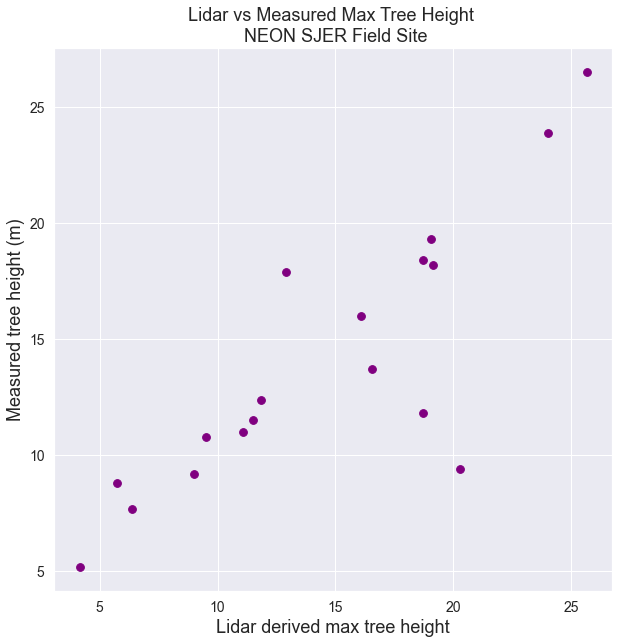

In [17]:
# Convert to a dataframe so you can use standard pandas plotting
SJER_final_height_df = pd.DataFrame(SJER_final_height)

fig, ax = plt.subplots(figsize=(10, 10))

SJER_final_height_df.plot("lidar_max",
                         "insitu_max",
                         kind="scatter",
                         fontsize=14, s=60,
                         color="purple",
                         ax=ax)

ax.set(xlabel="Lidar derived max tree height",
      ylabel="Measured tree height (m)",
      title="Lidar vs Measured Max Tree Height \n NEON SJER Field Site")

plt.show()

Next, let's fix the plot by adding a 1:1 line and making the x and y axis the same.

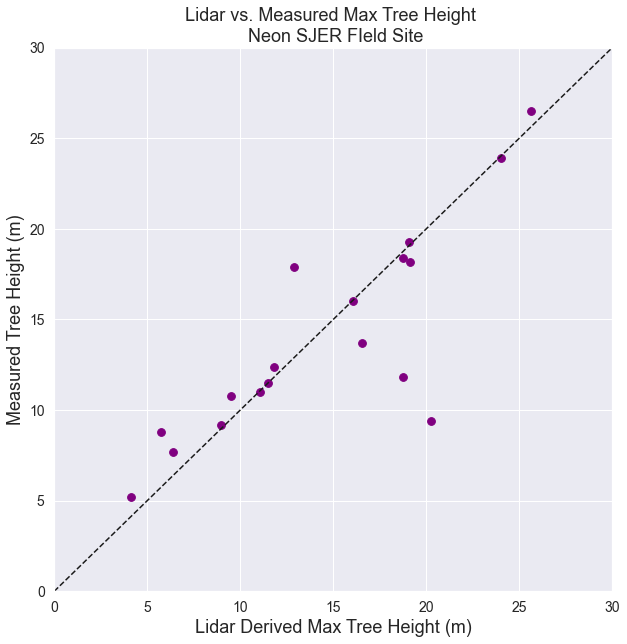

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

SJER_final_height_df.plot("lidar_max",
                         "insitu_max",
                         kind="scatter",
                         fontsize=14,
                         color="purple",
                         s=60, ax=ax)

ax.set(xlabel="Lidar Derived Max Tree Height (m)",
      ylabel="Measured Tree Height (m)",
      title="Lidar vs. Measured Max Tree Height \n Neon SJER FIeld Site")

# Add 1:1 line
ax.plot((0, 1), (0, 1),
       transform=ax.transAxes, ls="--", c="k")

# Adjust x and y axis limits
ax.set(xlim=[0, 30], ylim=[0, 30])
plt.show()

### Export Results as a .csv file

dataframe_name.to_csv("data/spatial-vector-lidar/outputs/sjer-lidar-insitu-merge.csv")

In [22]:
# Export the final dataframe as a csv file
outpath = os.path.join("data", "spatial-vector-lidar",
                      "outputs", "sjer-lidar-insitu-merge.csv")

SJER_final_height_df.to_csv(outpath)

## Create map of plot locations sized by tree height

Finally, you may want to create a map where points are sized according to tree height. To do that you:
1. Create or use a point geometry for each site location. In the case below we are using the data.frame that had the buffered points, and updating the geometry so that it is a point rather than the buffered polygon geometry.
2. Then you set the point markersize using an attribute in your geodataframe.. In the example below you use insitu_maxht

In [23]:
# Convert the geometry column to contain points
SJER_final_height["geometry"] = SJER_final_height.centroid
SJER_final_height.head()

SJER_final_height["insitu_max"]

0     19.3
1     23.9
2     16.0
3     11.0
4      8.8
5     18.2
6     13.7
7     12.4
8      9.4
9     17.9
10     9.2
11    11.8
12    11.5
13    10.8
14     5.2
15    26.5
16    18.4
17     7.7
Name: insitu_max, dtype: float64

Plot the points by tree height.

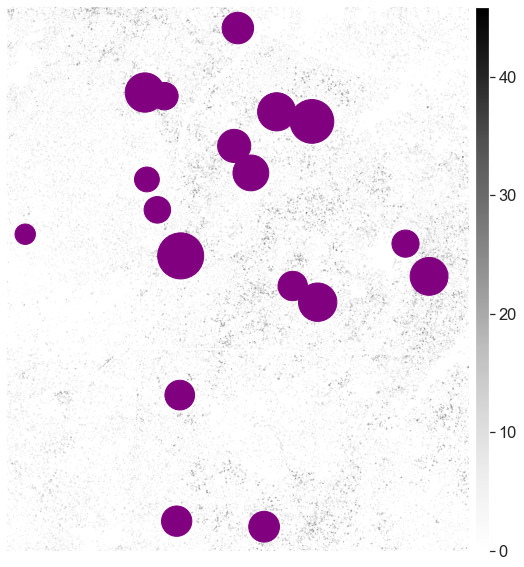

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
ep.plot_bands(SJER_chm_data,
             cmap="Greys",
             extent=sjer_chm_plt,
             ax=ax,
             scale=False)

# Plot centroids of each geometry as points so that you can control their size
SJER_final_height.centroid.plot(ax=ax,
                                marker="o",
                                markersize=SJER_final_height["insitu_max"]*80,
                                c="purple")
ax.set_axis_off()
plt.show()

### Create difference bar plot: Lidar vs measured

The last comparison that you may wish to explore is the plot by plot difference between lidar and measured tree height data. This is often helpful when you are trying to troubleshoot outlier values in your data. FOr instance you may notice that a few plots have very large differences between lidar and measured tree height.

You may decide to either:
1. Visit the sites if you are close to the field site or
2. Explore imagery for the sites to see if you can figure out a good reason for why the results may be so different.

Below you do the following
1. You 1st subtract field measured tree height from lidar estimates
2. Then you create a barplot of that value

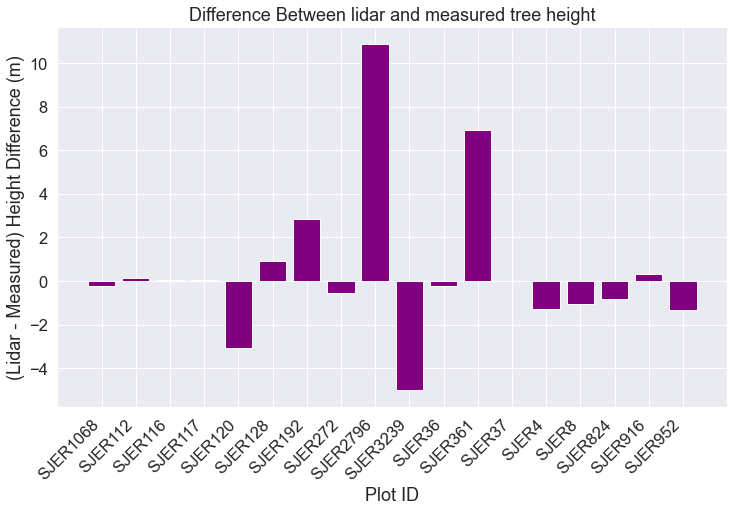

In [27]:
# Calculate difference
SJER_final_height["lidar_measured"] = SJER_final_height["lidar_max"] - \
    SJER_final_height["insitu_max"]

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(SJER_final_height["plotid"],
      SJER_final_height["lidar_measured"],
      color="purple")

ax.set(xlabel="Plot ID", ylabel="(Lidar - Measured) Height Difference (m)",
      title="Difference Between lidar and measured tree height")

plt.setp(ax.get_xticklabels(),
        rotation=45, horizontalalignment="right")

plt.show()